# The Relative Importance of Science in Daily Life and Compliance to Covid Stay at Home Orders

# Submission for Fundamentals of Social Data Science
## December 9 2020
## Candidate number: ------

# Part 1 Setup
### Literature review:

The Covid-19 pandemic has profoundly affected virtually all aspects of human life in 2020. Governments accross the world have implemented various restrictions to reduce the spread of the disease. There are various factors that effect public compliance to these restrictions, some of which are outside the government's control, such as public values. Several studies have examined the effect of certain public values on compliance, such as people's sense of duty (Kristina Murphy, 2020), or people's trust in the government (Bargain,2020). People's trust in science is an important value that has received relatively little attention in literature. One study measured the compliance of COVID-19 prevention guidelines using an online survey, and determined that more trust in science is associated with more precautionary behaviors such as "Covering your mouth and nose with your bent elbow or tissue when you cough or sneeze" (Musil, 2020). However, this study did not use any large data sources, such as mobility trends, and other readily available data sources to measure compliance. To the best of my knowledge, there does not appear to be studies that leverage big data to determine if there's an association between the relative importance of science in people's lives and compliance to government restrictions. I aim to fill this gap using data from the readily available OxCOVID19 Database (Mahdi et al., 2020).



### Data and Methodology

I used three datasets from the OxCOVID19 Database to answer my research question. The first dataset is the world bank values survey. This dataset contains countries' responses to several questions aimed at determining the relative importance of values of each country. The second dataset is the government response dataset, which contains various flags on when a country implemented certain policies to combat the pandemic, as well as various indexes to quantify the governments overall response on a scale from 0 to 100. The third dataset is the Google mobility dataset, which contains the change in mobility of various activity types relative to a baseline in early 2020 for a plethora of countries. All of these datasets were cleaned and merged using the steps below.

I decided to follow a similar procedure to Bargain's (2020) work because their article is well cited and used Google mobility trends to determine the effect of a public value. Moreover, I expect my results to be similar to their study, except for a different public value as my independant variable (in their case trust in governments), since I believe that analogously to high trust in governments, countries that highly value science will have higher compliance to lockdowns than groups that value science to a lesser extent. Consequently, a lot of my procedure is similar to their analysis, with a few notable differences. Bargain (2020) showed that the largest difference in compliance between areas with high and low trust in the government appeared after countries went into lockdown, therefore I analyzed the change in compliance after stay at home orders were issued for each country. I analyzed the change in mobility using a time window of 30 days after the first lockdown of each country, rather than the change in mobility from March 1st like the work of Bargain (2020). My approach of measuring mobility changes starting at the lockdown date makes sense in the context of my analysis, since I am not limiting my analysis to European countries as they did in their manuscript. Various countries locked down at different dates, but European countries appear to have locked down at nearly the same time. This is not the case at a global scale. The 30 day time window reflects the period used in Bargain's (2020) analysis, since they measured mobility trends until approximetly 1 month after March 1st. The steps used in my analysis are as follows.

To begin, I cleaned the world bank data and extracted responses to the question "It is not important for me to know about science in my daily life". I extracted the proportion of respondents that responded between one to nine, one meaning they strongly disagree with the statement and nine meaning they strongly agree. I normalized the proportions so that the sum of the proportion of respondents that answered the question from one to nine was 1, since some people opted not to answer the questions. I subsequently calculated the average response of each country that were asked this question. Next, I followed a similar procedure as Bargain (2020) to label countries that believed science played an important role in their lives as countries with a average response below the mean (since a high score in this survey means that the respondents had low trust in science).

Next, I queried the government response data, and extracted the date the first general stay at home orders were issued for each country. This was done by taking the first occurrence there was a change from either Null or 0 to 1 for the stay at home flag, where 1 means there was a general stay at home order. 

I subsequently queried the Google mobility data and merged it with the government response and world bank data. Mobility data was filtered to only include data from the start until 30 days after the start date of the stay at home orders for each country. I inlcuded mobility trends for the following six activities: transit stations, residential, workplace, parks, retail & recreation, grocery & pharmacy. Next, the average mobility of each country was computed for each 30 day period, and I compared countries that associated a high/low importance to science to each other using a t-test to test my null hypothesis. My null hypothesis is that, for each activity type, countries with have a high percentage of people that find science important in their every day life will have the same drop in mobility as countries that do not, and a p-value of less than 0.05 would enable me to reject the null hypothesis. 



In [9]:
# Part 1 code 
# Import statements and function calls

import pandas as pd
import re
import geopandas
import geoplot
import psycopg2
from scipy import stats
import matplotlib
from pandas.plotting import register_matplotlib_converters 
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Importing and cleaning the world bank survey data

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()


sql_command = """SELECT * FROM surveys"""
world_bank_stats_df = pd.read_sql(sql_command, conn)


# Only include country-level data
world_bank_stats_df = world_bank_stats_df[pd.isna(world_bank_stats_df['adm_area_1'])]

# Extract the proportion of responses for each question and include it as its own column
for i in range(1,10):
    col_name = 'Proportion ' + str(i)
    p_ans_key = 'I002_' + str(i)
    answers_series = world_bank_stats_df['properties'].map(lambda x: x['I002']['Frequencies'][p_ans_key])
    if i==1:
        world_bank_stats_df['tot proportion answered'] = answers_series.copy()
    else:
        world_bank_stats_df['tot proportion answered'] +=  answers_series.copy()
    world_bank_stats_df[col_name] = answers_series.copy()
    
    # Only take rows where people actually responded to the survey
world_bank_stats_df = world_bank_stats_df[world_bank_stats_df['tot proportion answered']>0.1]
    
# Normalizing scores (so that the total proportion from 1-9 is 1), and calculating the average score
for i in range(1,10):
    col_name = 'Proportion ' + str(i)
    if i==1:
        world_bank_stats_df['average score'] = world_bank_stats_df[col_name]*i/world_bank_stats_df['tot proportion answered']
    else:
        world_bank_stats_df['average score'] += world_bank_stats_df[col_name]*i/world_bank_stats_df['tot proportion answered']


print('Num countries responded to survey question: ',str(len(world_bank_stats_df)))


Num countries responded to survey question:  60


In [11]:
# Obtain data from the Government_response table
cur = conn.cursor()
cur.execute("""SELECT * FROM government_response WHERE date<now() ORDER BY date""")
govtrack_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])


In [12]:

# Find all countries where there are duplicates in terms of the number of countries, and find the most relevant to keep
combinations = govtrack_data.groupby(['countrycode','country']).size().reset_index().rename(columns={0:'count'})
country_and_code_occurence = combinations.groupby('countrycode').count()
non_distinct_cols = country_and_code_occurence[country_and_code_occurence['count']==1]
country_and_codes = non_distinct_cols.merge(combinations,left_on='countrycode',right_on="countrycode", how = 'inner')

# Look like countries either have 339, or 209 values (Therefore anything without 339 values can be considered a duplicate.
# Therefore simply just pick any country with a count equal to the median value (which is 339 in this case)
# display(country_and_codes)

filter_value = combinations['count'].median()
relevant_countries_df = combinations[combinations['count']==filter_value][['country','countrycode']]



In [13]:
# Calculating stay at home orders

govtrack_data['stay_at_home_prev'] = govtrack_data.groupby(['country'])['c6_flag'].shift(1)

# Filtering for relevant countries
govtrack_data = govtrack_data.merge(relevant_countries_df,left_on='country',right_on="country", how = 'inner')


change = govtrack_data[np.logical_and(govtrack_data['stay_at_home_prev'] !=1, govtrack_data['c6_flag'] == 1)]

# First lockdown date
stay_at_home_dates_countries = change[['date','country']].groupby('country').min()


stay_at_home_dates_countries = stay_at_home_dates_countries.rename(columns={'date': "stay_at_home_date"})

In [14]:
#Getting google mobility data
source = "GOOGLE_MOBILITY"
sql_command = """SELECT * FROM mobility WHERE source=%(source)s"""
mobility_df = pd.read_sql(sql_command, conn, params={'source': source})

# Only include country level data
mobility_df = mobility_df[pd.isnull(mobility_df['adm_area_1'])]
# mobility_df['date'] = mobility_df['date'].map( lambda datetext: datetime.strptime(datetext, '%d-%m-%Y'))
display(mobility_df.head())


,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,transit_stations,residential,workplace,parks,retail_recreation,grocery_pharmacy,gid,transit,walking,driving
36,GOOGLE_MOBILITY,2020-03-11,Burkina Faso,BFA,None,None,None,-6.0,0.0,5.0,-4.0,-1.0,1.0,[BFA],None,None,None
42,GOOGLE_MOBILITY,2020-03-10,Burkina Faso,BFA,None,None,None,1.0,0.0,6.0,1.0,0.0,2.0,[BFA],None,None,None
49,GOOGLE_MOBILITY,2020-05-16,Slovenia,SVN,None,None,None,-18.0,4.0,-10.0,12.0,-26.0,-4.0,[SVN],None,None,None
156,GOOGLE_MOBILITY,2020-09-04,Indonesia,IDN,None,None,None,-33.0,12.0,-20.0,-11.0,-13.0,1.0,[IDN],None,None,None
171,GOOGLE_MOBILITY,2020-05-25,Slovenia,SVN,None,None,None,-28.0,7.0,-24.0,30.0,-9.0,-7.0,[SVN],None,None,None


In [15]:
# Merging all the data together

# Relevant activities used for the analysis
activity_lst = ['transit_stations','residential', 'workplace', 'parks', 'retail_recreation', 'grocery_pharmacy']

mobility_stay_at_home_df = mobility_df.merge(stay_at_home_dates_countries,left_on='country',right_index=True, how = 'inner')

# filtering data to only include data from the start of stay at home orders up until 30 days into their implementation
mobility_stay_at_home_df = mobility_stay_at_home_df[np.logical_and(\
                                                                   mobility_stay_at_home_df['date'] >= mobility_stay_at_home_df['stay_at_home_date'],\
                                                                   mobility_stay_at_home_df['date']- timedelta(days=30) <= mobility_stay_at_home_df['stay_at_home_date'])]

mobility_stay_at_home_df['days from stay at home start date'] = (mobility_stay_at_home_df['date']- mobility_stay_at_home_df['stay_at_home_date']).dt.days

mean_mobility_country_stay_at_home = mobility_stay_at_home_df[['country']+activity_lst].groupby('country').mean()

mean_mobility_stay_at_home_survey_qs = mean_mobility_country_stay_at_home.merge(world_bank_stats_df,left_index=True,right_on="country", how = 'inner')

mean_importance_val = mean_mobility_stay_at_home_survey_qs['average score'].mean()

# Countries with a average score below the median have a high trust in science (recall question is 
# "It is not important for me to know about science in my daily life")
mean_mobility_stay_at_home_survey_qs['Highly important to know science'] = mean_mobility_stay_at_home_survey_qs['average score'].map(lambda x: x<=mean_importance_val)

In [16]:
# Getting continent data to determine the distribution of continents

world_df = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)


# Used in part 2, since Geopandas is not compatible with packages in my environment for part 2.
pd.DataFrame(world_df).to_csv('world.csv')

# Getting a charined assignment warning here, even though it does not look like I am making a chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

# Geopandas dataframe used later to append the missing data
country_lst_geopandas_continent = world_df[['name','continent']]
country_lst_geopandas = world_df['name'].to_list()

country_dict_geopandas = {country:country for country in country_lst_geopandas}
country_dict_geopandas['United States of America'] = 'United States'
country_lst_geopandas_continent['name'] = country_lst_geopandas_continent['name'].map(country_dict_geopandas)

# It appears that both Singapore and Hong Kong are missing from the geopandas dataframe (even though hongkong it;s debatable if hong kong is an
# an independant country, I'm adding them anyway)
add_geopandas_df = pd.DataFrame([['Hong Kong','Asia'],['Singapore', 'Asia']],columns = ['name','continent'])

# Append these 2 additional rows to the dataframe
country_lst_geopandas_continent = country_lst_geopandas_continent.append(add_geopandas_df)

# Merge the data together to get the continent of each of the 48 countries
countries_mobility_df_to_merge =  mean_mobility_stay_at_home_survey_qs[['country']]

country_and_codes = country_lst_geopandas_continent.merge(countries_mobility_df_to_merge,left_on='name',right_on="country", how = 'inner')

# Display the number of countries in each continent used in my study
continent_counts = country_and_codes[['continent','country']].groupby('continent').count().add_suffix(' count').reset_index()
tot_sum = pd.DataFrame([['Total',continent_counts['country count'].sum()]],columns = ['continent','country count'])
continent_counts = continent_counts.append(tot_sum)
continent_counts['proportion'] = continent_counts['country count']/tot_sum.loc[tot_sum.index[0],'country count']

display(continent_counts)
print(' Table 1: Distribution of countries')
print('     in this study by continent.')

,continent,country count,proportion
0,Africa,8,0.166667
1,Asia,19,0.395833
2,Europe,9,0.187500
3,North America,4,0.083333
4,Oceania,2,0.041667
5,South America,6,0.125000
0,Total,48,1.000000


 Table 1: Distribution of countries
     in this study by continent.


,Activity Type,Mean Change in Mobility Low Importance in Science,Mean Change in Mobility High Importance in Science,p-value
0,transit_stations,-59.771712,-52.933162,0.2297
1,residential,22.849876,19.240103,0.1367
2,workplace,-48.598015,-42.041972,0.167
3,parks,-48.058313,-24.622862,0.0116*
4,retail_recreation,-60.352357,-50.085899,0.0649
5,grocery_pharmacy,-35.203474,-26.845064,0.1204


            Table 2: Change in mobility for each activity type and high/low importance in science groups.
                                      A star next to the pvalue indicates statistical





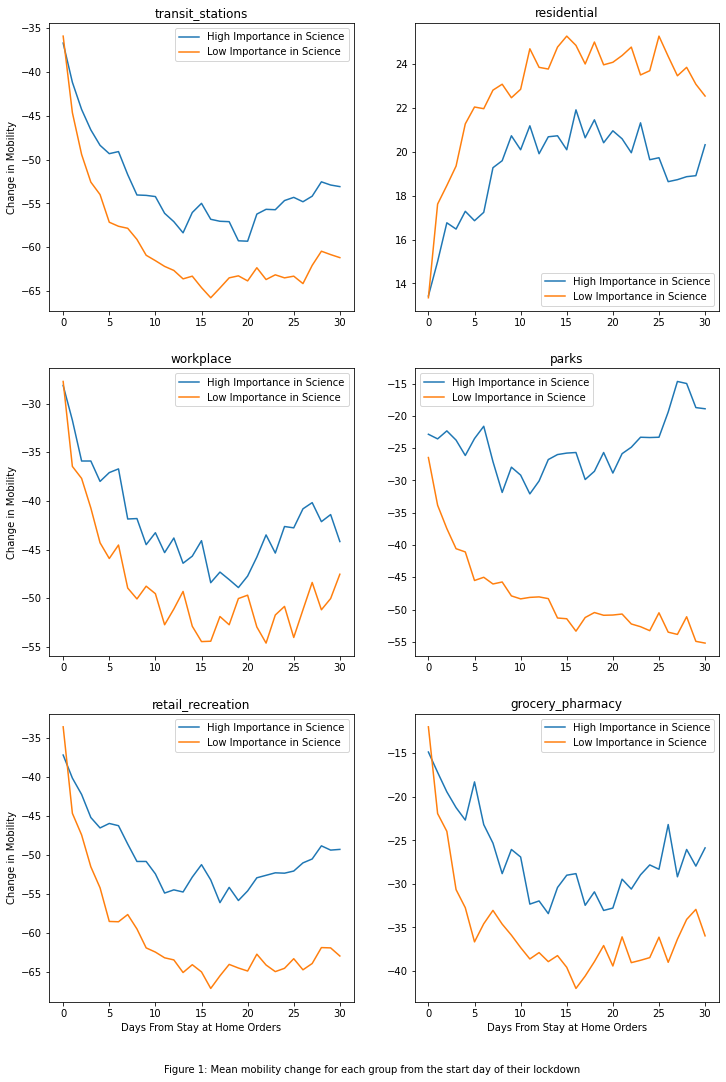

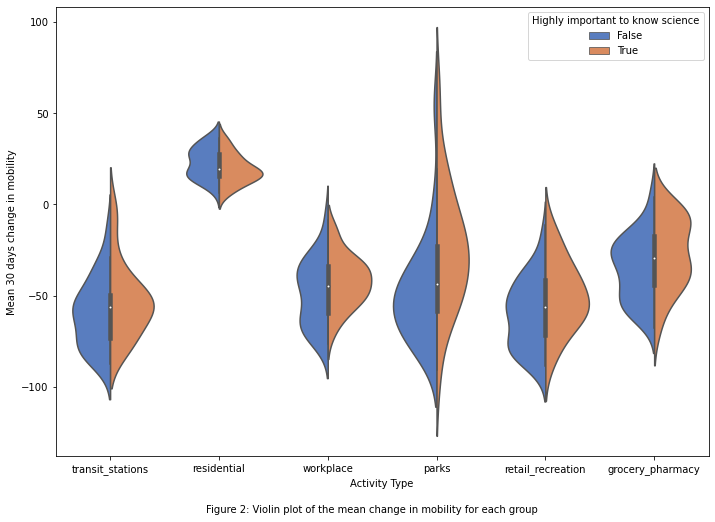

In [17]:
# Plotting the rest of the results

# Creating a dataframe with the activity type, the mean mobility for high and low importance in science and
# the p_value between each distribution for each activity
df_constructor_activity_p_vals = list()
for activity in activity_lst:
    high_trust_mobility_lst = mean_mobility_stay_at_home_survey_qs[mean_mobility_stay_at_home_survey_qs['Highly important to know science']==True][activity].to_list()
    low_trust_mobility_lst = mean_mobility_stay_at_home_survey_qs[mean_mobility_stay_at_home_survey_qs['Highly important to know science']==False][activity].to_list()
    p_val = stats.ttest_ind(high_trust_mobility_lst,low_trust_mobility_lst)[1]
    # Adding an asterics next to pvalues that are significant (less than 0.05) an rounding the value to the nearest 4th decimal place
    if p_val < 0.05:
        p_val_str = str(round(p_val,4)) + '*'
    else:
        p_val_str = str(round(p_val,4))
    df_constructor_activity_p_vals.append([activity,sum(low_trust_mobility_lst)/len(low_trust_mobility_lst),\
                                           sum(high_trust_mobility_lst)/len(high_trust_mobility_lst),\
                                           p_val_str])

p_val_df = pd.DataFrame(df_constructor_activity_p_vals,columns = ['Activity Type','Mean Change in Mobility Low Importance in Science',\
                                                                  'Mean Change in Mobility High Importance in Science','p-value'])
display(p_val_df)
print('            Table 2: Change in mobility for each activity type and high/low importance in science groups.')
print('                                      A star next to the pvalue indicates statistical')


# Average mobility each day for both groups (by grouping by day)
mobility_stay_at_home_df_days_world_bank = mobility_stay_at_home_df.merge(world_bank_stats_df,left_on='country',right_on="country", how = 'inner')
mobility_stay_at_home_df_days_world_bank['Highly important to know science'] = mobility_stay_at_home_df_days_world_bank['average score'].map(lambda x: x<=mean_importance_val)


days_trust_groups = mobility_stay_at_home_df_days_world_bank[['days from stay at home start date','Highly important to know science']+activity_lst]\
.groupby(['days from stay at home start date','Highly important to know science']).mean().reset_index()

# Plotting the average mobility curves of both groups
fig, axs = plt.subplots(3, 2, sharex=False, sharey=False,figsize=[12,18])
dates_plt = pd.unique(days_trust_groups['days from stay at home start date'])
for ct,activity in enumerate(activity_lst):
    high_trust_days = days_trust_groups[days_trust_groups['Highly important to know science']==True][activity].to_list()
    low_trust_days = days_trust_groups[days_trust_groups['Highly important to know science']==False][activity].to_list()

    subplt_x = ct//2
    subplt_y = ct%2
    axs[subplt_x, subplt_y].plot(dates_plt,high_trust_days)
    axs[subplt_x, subplt_y].plot(dates_plt,low_trust_days)

    axs[subplt_x,subplt_y].legend(['High Importance in Science','Low Importance in Science'])
    axs[subplt_x,subplt_y].set_title(activity)
    
    # Only include axis titles on the left and the buttom of the figure to avoid things getting to messy
    if subplt_y==0:
        axs[subplt_x,subplt_y].set(ylabel='Change in Mobility')
    if subplt_x==2:
        axs[subplt_x,subplt_y].set(xlabel='Days From Stay at Home Orders')
print('\n\n')
fig.text(.5, .07, 'Figure 1: Mean mobility change for each group from the start day of their lockdown ', ha='center')
plt.show()

# creating violin plot of the distribution of mobilities (for the mean mobility of each country)
mean_mobility_important_cols = mean_mobility_stay_at_home_survey_qs[['Highly important to know science']+activity_lst]
mobility_means_melted = pd.melt(mean_mobility_important_cols, id_vars=['Highly important to know science'], value_vars=activity_lst)
mobility_means_melted = mobility_means_melted.rename(columns={'value': "Mean 30 days change in mobility",'variable': "Activity Type"})
a4_dims = (11.7, 8.27)

fig, ax = matplotlib.pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(x="Activity Type", y="Mean 30 days change in mobility", hue="Highly important to know science",
                    data=mobility_means_melted, palette="muted",split=True,figsize = [20,10])
ax.figsize = [10,10]

print('\n\n')
fig.text(.5, .03, 'Figure 2: Violin plot of the mean change in mobility for each group', ha='center')
plt.show()


# Discussion

Before examining the mobility trends, it is important to discuss the sample of countries included in this study. Only includes 60 countries answered the world bank survey in 2010 (and it appears to be the only year the question was asked in this dataset). After cleaning the data, and merging all three of the tables, our resulting sample size of countries is 48. Table 1 shows that the distribution of countries that remained for my analysis. It can be seen from Table 1 that a significant percentage of the data used for this analysis is from Asia, Europe and Africa.

Figure 1 shows that there appears to be a visual difference in the mobility change between the two groups for all the different activity types once stay at home orders begin. Similarly to the results of (Bargain, 2020), the mobility patterns seem to be relatively close for the first few days of stay at home orders, and diverge thereafter. However, unlike Bargain's (2020) result, the mobility patterns of non-residential activities appear to diverge in the opposite direction that we would expect, with countries associating a low importance to science reducing their mobility more than the high importance group. Countries that associate a low value to science appear to also spend more time at home than their high-value counterparts, which is also not what I expected. 

Despite the obvervational difference between groups, there was no statistically significant difference between the average 30-day mobility change between the two groups for most activity types. Table 2 highlights all the p values as well as the mean mobility changes of each group. We see that for all group except for one notable exception, the pvalue is greater than 0.05, so we fail to reject the null hypotheses, and conclude that the distributions are the same. The mobility at parks had a pvalue of 0.016, therefore it appears that countries that associate a low importance to science reduced their mobility significantly more than the other group for activities at parks. A violin plot of the various distributions can be observed in Figure 2. It can be seen from this plot that most distributions of the two groups are indeed quite similar for most activities, and appears to have a very high variance for both groups for the parks activity.

One way to explain the higher mobility in outdoor spaces such as parks could be that people with a high trust in science are aware that Covid-19 does not spread well outdoors (Freeman, 2020), so spend more time performing this type of activity. This could also partially explain why the residential mobility trends are not lower for this group, since these people are spending more time outdoors than the other group. 

# Part 2 Setup

### Literature review
With the advent of social media and large data sources, public sentiment has become a variable commonly measured and analyzed by researchers. Common data sources include popular platforms, such as Twitter (Pak, 2012), Facebook (Ortigosa &amp; Martín, 2013) and Youtube (Plank, 2014). Since March 2020, Covid-19 has changed virtually all aspects of life accross the globe, causing increased anxiety and overall negative emotions (Montemurro, 2020). Some researchers have endeavored to utilize big data sources to measure public sentiment changes due to Covid. Most research in this area focuses on sentiment analysis using twitter. (Medford, 2020) determined that the number of tweets associated with Covid-19 during the early days of the pandemic - mid to late January 2020 - increased as the daily number of cases increased, and most of the tweets were negative. Another study examined the public sentiment in Australia over time using Twitter and determined that the public sentiment decreased when cases peaked (Zhou, 2020). Other data sources, such as Youtube, appear not to have been leveraged much during this pandemic to measure public opinion changes caused by Covid; most Youtube studies appear to study the spread of disinformation instead. Due to this gap in literature, I would like to determine if there is an association between the public's perception of Covid related youtube videos and a country's recent number of covid cases. I would also like to determine if there is an increased number of Covid youtube videos in a country as cases increase. To answer this research question I will use the Youtube Data API (V3), the Google Translate API and the OxCOVID19 data.

### Data sources and Methodology
The Youtube Data API enables us to fetch search results such as videos, channels and playlists as well as extract video and channel statistics. The Youtube API requires an API key, and has a relatively low daily quota limit, therefore API calls were made sparingly. Before extracting Youtube data, Covid cases and death counts were extracted for the past 2 weeks using the the epidimiology table in the OxCOVID19 dataset. Next these values were filtered to include only western countries - all countries in Europe and Oceana as well as Canada and the United States using the geopandas "world" dataset. This was done to limit the number of API calls, since requesting data on all countries would exceed the API daily quota. Next the cases and death metrics were converted to "cases/deaths per 1000 people", by dividing by the population of each country using the population column of the geopandas word dataset.

Next, I used to Youtube data API to determine the top three news channel for each country by querying the country name followed by the words "news channel". For example if the country was Canada, the query would be "Canada news channel". Unpopular channels occasional reach the top of the search list, and irrelevant, high-subscriber channels are usually visible after five search results, which is why I selected three results, as it appeared to work best for these purposes. I subsequently extracted the number of subscribers for each channel, and retained the channel with the top number of subscribers - This was done to limit the number of API calls for later steps in the algorithm, by extracting the most relevant channel of the three options. I proceeded to extract 50 videos from each country's news channel - The Youtube data API does not allow me to filter the upload date for each channel, so I could only fetch the most recent videos. Next, I determined which videos had certain covid-related search words in the title. The search words were translated using the Google translate API. The target language was determined using Google APIs detected language on the video title. The English search words are shown in table 3. Once the videos were flagged as Covid or non-Covid, I calculated the total number of Covid and non-Covid videos and calculated the like to dislike ratio of both types of videos. Next I calculated the difference between the like-dislike ratio of both groups to measure how much people dislike Covid videos relative to non-Covid videos.

Finally, I merged this data to the epimidiology with the cases/deaths per 1000 people and plotted the association between Covid cases/deaths and the number of Covid related videos, as well as the difference in like-dislike ratio between video types to determine if these and plotted a line of best fit for each of these four relationships.

In [1]:
# Part 2 code

# Import statements and functions
import psycopg2
import pandas as pd
import scipy.stats
from datetime import timedelta
import numpy as np
from googleapiclient.discovery import build
import pandas as pd
import google_trans_new
from google_trans_new import google_translator  
import matplotlib.pyplot as plt
import my_youtube_api_key

# Clean the video descriptions
def clean_description(description_str):
    if 'http' in description_str:
        first_link_post = description_str.index('http')
        return description_str[:first_link_post]
    else:
        return description_str
    

In [8]:
# Getting epidemiology data
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

source = "GBR_PHTW"

sql_command = """SELECT * FROM epidemiology ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command, conn, params={'source': source})


In [3]:
# Limiting the analysis to "Western countries", and calculating the number of cases per capita

# Getting world df from the geopandas "naturalearth_lowres" file. NOTE: This dataframe was saved during part 1 to a csv file, since geopandas conflicted with
# some packages in this virtual environment. I use a different kernel to run part 2
world_df = pd.read_csv('world_df.csv')

df_epidemiology_countries = df_epidemiology[pd.isnull(df_epidemiology['adm_area_1'])]
df_epidemiology_new = df_epidemiology_countries.copy()
df_epidemiology_new['date str'] = df_epidemiology_new['date'].map(lambda x: x.strftime('%m/%d/%Y'))


df_yesterday = df_epidemiology_new[df_epidemiology_new['date str']==(pd.to_datetime('today')- timedelta(days=1)).strftime('%m/%d/%Y')]
culm_cases_yersterday= df_yesterday[['country','confirmed','dead']].groupby('country').mean().add_suffix("_yesterday")



df_15_days_ago = df_epidemiology_new[df_epidemiology_new['date str']==(pd.to_datetime('today')- timedelta(days=15)).strftime('%m/%d/%Y')]
culm_cases_15_days_ago= df_15_days_ago[['country','confirmed','dead']].groupby('country').mean().add_suffix("_15_days_ago")

cases_merged = culm_cases_yersterday.merge(culm_cases_15_days_ago,left_index = True,right_index = True, how = 'inner')
cases_merged['confirmed_cases_past_2_weeks'] = cases_merged['confirmed_yesterday'] - cases_merged['confirmed_15_days_ago']
cases_merged['confirmed_deaths_past_2_weeks'] = cases_merged['dead_yesterday'] - cases_merged['dead_15_days_ago']





####################3
relevant_countries = world_df[world_df['continent'].isin(['Europe','North America','Oceania'])]
relevant_countries = relevant_countries[np.logical_or(\
                                                      relevant_countries['continent']!='North America',\
                                                      relevant_countries['name'].isin(['Canada','United States of America']))]
relevant_countries = relevant_countries[~relevant_countries['name'].isin(['Ukraine','Russia'])]
# relevant_countries = relevant_countries[relevant_countries['name']!='Russia']


country_lst = relevant_countries['name'].to_list()



country_dict = {country:country for country in country_lst}
# country_dict['United Kingdom of Great Britain and Northern Ireland'] = 'United Kingdom'
country_dict['United States of America'] = 'United States'

relevant_countries['name'] = relevant_countries['name'].map(country_dict)

# Removing countries with a population under 1 million
relevant_countries= relevant_countries[relevant_countries['pop_est']>=1e6]



relevant_vals = cases_merged.merge(relevant_countries,left_index = True,right_on = 'name', how = 'inner')
# display(df_yesterday)
relevant_vals['cases per 1000 past 2 weeks'] =relevant_vals['confirmed_cases_past_2_weeks']/relevant_vals['pop_est']*1000.0
relevant_vals['deaths per 1000 past 2 weeks'] =relevant_vals['confirmed_deaths_past_2_weeks']/relevant_vals['pop_est']*1000.0

relevant_vals = relevant_vals.rename(columns={'name': "Country"})

# print((pd.to_datetime('today')- timedelta(days=1)).strftime('%m/%d/%Y'))
# display(cases_merged)

# display(relevant_vals)

# print(len(relevant_vals))
countries = relevant_vals['Country'].to_list()

In [4]:
#creating a table of the key words
covid_key_words = ['Covid','Coronavirus','Pandemic','Corona','Virus']
table_3 = pd.DataFrame([covid_key_words],columns=['Search Term ' + str(i) for i in range(len(covid_key_words))])

display(table_3)
print('Table 3: Covid search terms used. It should be noted that')
print('the word \"Coronavirus\" is included even though both')
print('\"Corona\" and  \"Virus\" are included, since the')
print('translated \"Coronavirus\" might not contain either')
print('word once they are both translated')

,Search Term 0,Search Term 1,Search Term 2,Search Term 3,Search Term 4
0,Covid,Coronavirus,Pandemic,Corona,Virus


Table 3: Covid search terms used. It should be noted that
the word "Coronavirus" is included even though both
"Corona" and  "Virus" are included, since the
translated "Coronavirus" might not contain either
word once they are both translated


In [5]:
# Getting Youtube Data
youtube = build('youtube', 'v3', developerKey=api_key)
translator = google_translator() 


# countries = ['United States','Canada','Germany']


# All items that will be saved as we iterate through countries
num_vids = 50
num_relevanat_channels = 3
tot_likes = list()
tot_dislikes = list()
tot_ratio = list()
best_channel_match_name = list()
tot_covid_vids = list()
channel_languages = list()
num_likes_disabled_lst = list()

tot_likes_non_covid = list()
tot_dislikes_non_covid = list()
tot_ratio_non_covid = list()
tot_non_covid_vids = list()
all_vids_list = list()
for country in countries:

    query = country + ' news channel'
    # Getting relevant channels
    
    # fectching 3 news channels related to the country
    # Cost 100 quotas for this request
    req_channels = youtube.search().list(q=query, part = 'snippet', type = 'channel',maxResults = num_relevanat_channels)
    result_channels = req_channels.execute()

    # extracting the ID of all channels to be able to query them
    channel_ids = list()
    channel_names = list()

    for results_num in range(num_relevanat_channels):
        channel_ids.append(result_channels['items'][results_num]['id']['channelId'])
        channel_names.append(result_channels['items'][results_num]['snippet']['title'])
#         print(channel_names[-1])

    # print(channel_ids)

    # Getting the channel stats for all channels and determine all their numbers of subscribers
    # Cost 1 quota per stat
    request_channel_stats = youtube.channels().list(part = 'statistics', id = channel_ids)
    channel_stats = request_channel_stats.execute()
    # Note: Items are not returned in the order the they are queried!!

    # getting subscriber count of all channel (of the channels that have it enabled)
    sub_count = list()
    for i in range(num_relevanat_channels):
        if(channel_stats['items'][i]['statistics']['hiddenSubscriberCount']==False):
            sub_count.append(int(channel_stats['items'][i]['statistics']['subscriberCount']))
        else:
            sub_count.append(0)

    Best_match_result_index = sub_count.index(max(sub_count))
    channel_id = channel_stats['items'][Best_match_result_index]['id']
    # print(channel_ids[Best_match_result_index])
    index_best_channel = channel_ids.index(channel_id)

    
    # Used later to return this
    best_channel_match_name.append(channel_names[index_best_channel])
#     print(best_channel_match_name)

    # Getting a pointer to the videos
    request_channel_info = youtube.channels().list(
            part='contentDetails',
            id=channel_id
        )
    channel_info = request_channel_info.execute()

    # All videos pointer
    all_video_ids = channel_info['items'][0]['contentDetails']['relatedPlaylists']['uploads']


    # Getting 50 videos from the channel (cost 1 quota per video so 50 quotas total)
    videos_request = youtube.playlistItems().list(playlistId=all_video_ids, part = 'snippet', maxResults = num_vids)
    videos = videos_request.execute()  

    # Only perform an analysis on the channel if videos were returned
    if videos['pageInfo']['totalResults'] > 0:
        vid_ids = list()
        vid_titles = list()
        vid_descriptions = list()
        for result_num in range(len((videos['items']))):
            vid_titles.append(videos['items'][result_num]['snippet']['title'])
            vid_descriptions.append(videos['items'][result_num]['snippet']['description'])
            vid_ids.append(videos['items'][result_num]['snippet']['resourceId']['videoId'])

    #     print(vid_ids)
        # print(vid_titles)

        # Getting video stats (including likes and dislikes) 
        # 1 quota per video (50 quotas total)
        vid_details_request = youtube.videos().list(part = 'statistics', id=vid_ids)
        vid_details = vid_details_request.execute()
        all_vids_list.append(vid_details)

        # Getting like/dislike info from videos
        like_ratios = list()
        num_likes = list()
        num_dislikes = list()
        num_covid_vids = 0
        num_likes_disabled = 0
        
        num_likes_non_covid = list()
        num_dislikes_non_covid = list()
        like_ratios_non_covid = list()
        num_non_covid_vids = 0
        

        # Determine language of first video description, and assume it's the same for all videos on the channel
        language_detected = translator.detect(vid_titles[0])
        channel_languages.append(language_detected)
        
        # Translate all key words using the detected language
        covid_key_words_translated = list()
        for i in range(len(covid_key_words)):
            covid_key_words_translated.append(translator.translate(covid_key_words[i],lang_tgt=language_detected[0]).strip(' ').lower())
        
        for vid_num in range(len(vid_details['items'])):
            vid_description_clean = clean_description(vid_descriptions[vid_num]).lower()
            vid_titles_clean =  vid_titles[vid_num].lower()
            
            #Determine if keywords are in either the video discription or the title
            key_words_in_title = any([translated_word in vid_titles_clean for translated_word in covid_key_words_translated])
            key_words_in_description = any([translated_word in vid_description_clean for translated_word in covid_key_words_translated])
            
            # Check if like count exists
            if 'likeCount' in vid_details['items'][vid_num]['statistics'].keys():
                # Ensuring the video doesn't have likes disabled
                if key_words_in_title or key_words_in_description:
                    num_likes.append(int(vid_details['items'][vid_num]['statistics']['likeCount']))
                    num_dislikes.append(int(vid_details['items'][vid_num]['statistics']['dislikeCount']))
                    like_ratios.append(num_likes[-1]/(num_likes[-1]+num_dislikes[-1]+0.001))
                    num_covid_vids += 1

#                     print('ratio = ', str(like_ratios[-1]),'   likes =', str(num_likes[-1]), '    dislikes =', str(num_dislikes[-1]),' Vid title = ', vid_titles[vid_num])
    #             print('vid description: ', vid_descriptions[vid_num])
#                     print('\n')
        
                else:
                    num_likes_non_covid.append(int(vid_details['items'][vid_num]['statistics']['likeCount']))
                    num_dislikes_non_covid.append(int(vid_details['items'][vid_num]['statistics']['dislikeCount']))
                    like_ratios_non_covid.append(num_likes_non_covid[-1]/(num_likes_non_covid[-1]+num_dislikes_non_covid[-1]+0.001))
                    num_non_covid_vids += 1     
            else:
#                 print('likes disabled')
                num_likes_disabled += 1
        
        # Appending all results of the country
        

        tot_likes.append(sum(num_likes))
        tot_dislikes.append(sum(num_dislikes))
        tot_ratio.append(tot_likes[-1]/(tot_likes[-1]+tot_dislikes[-1]+0.001))
        tot_covid_vids.append(num_covid_vids)
        num_likes_disabled_lst.append(num_likes_disabled)
        
        tot_likes_non_covid.append(sum(num_likes_non_covid))
        tot_dislikes_non_covid.append(sum(num_dislikes_non_covid))
        tot_ratio_non_covid.append(tot_likes_non_covid[-1]/(tot_likes_non_covid[-1]+tot_dislikes_non_covid[-1]+0.001))
        tot_non_covid_vids.append(num_non_covid_vids)
    else:
        # If something goes wrong, return -1 for all list items
        best_channel_match_name.append(-1)
        tot_likes.append(-1)
        tot_dislikes.append(-1)
        tot_ratio.append(-1)
        tot_covid_vids.append(-1)
        num_likes_disabled_lst.append(-1)
        
        tot_likes_non_covid.append(-1)
        tot_dislikes_non_covid.append(-1)
        tot_ratio_non_covid.append(-1)
        tot_non_covid_vids.append(-1)
        
        print('Channel has private vids')
        
    

#     print('likes =',str(tot_likes[-1]),'  dislikes =',str(tot_dislikes[-1]), '  ratio =',str(tot_ratio[-1]))




# search_words = ['covid, coronavirus','pandemic']


        


In [6]:

# Creating youtube dataframe
lst_youtube_vals = [[countries[i],best_channel_match_name[i],tot_likes[i],tot_dislikes[i],tot_ratio[i],tot_covid_vids[i],\
                    tot_likes_non_covid[i],tot_dislikes_non_covid[i],tot_ratio_non_covid[i],tot_non_covid_vids[i], channel_languages[i][1]]\
                    for i in range(len(countries))]
# lst_youtube_vals.



youtube_info_df = pd.DataFrame(lst_youtube_vals,columns = ['Country','Best Channel Match','Likes','Dislikes', 'Like dislike ratio', 'tot covid videos',\
                                                          'likes non covid', 'dislikes non covid', 'tot ratio non covid', 'non covid vids','channel language detected'])
# There could be up to 50 covid videos, but it's not guaranteed, so we use the ratio of covid videos and the sum of covid and non covid videos
youtube_info_df['proportion covid videos'] = youtube_info_df['tot covid videos']/(youtube_info_df['non covid vids'] +youtube_info_df['tot covid videos'])
# print(len(youtube_info_df[youtube_info_df['tot covid videos']>1]))

youtube_data_discarded = youtube_info_df[youtube_info_df['tot covid videos']<=1].copy()
youtube_data_keep = youtube_info_df[youtube_info_df['tot covid videos']>1]

# Getting a charined assignment warning here, even though it does not look like I am making a chained assignment
pd.options.mode.chained_assignment = None  # default='warn'
youtube_data_keep['diff ratio'] = youtube_data_keep['tot ratio non covid'] - youtube_data_keep['Like dislike ratio']

display(youtube_data_keep[['Country','Best Channel Match','channel language detected','Likes','Dislikes','Like dislike ratio']])
print('                     Table 4: News channel and extracted videos info')
print('\n')
display(youtube_data_discarded[['Country','Best Channel Match','channel language detected']])
print('                   Table 5: Discarded channel info')


,Country,Best Channel Match,channel language detected,Likes,Dislikes,Like dislike ratio
0,Albania,Top Channel Albania,albanian,41,5,0.891285
1,Australia,ABC News (Australia),english,489,402,0.548821
3,Belarus,Телеканал Дождь,russian,64317,5198,0.925225
6,Canada,CBC News,english,10494,15728,0.400198
8,Denmark,DR Nyheder,danish,18176,736,0.961083
9,Estonia,DW News,english,17106,1940,0.898141
11,France,FRANCE 24,french,542,1448,0.272362
12,Germany,DW News,english,17106,1940,0.898141
14,Hungary,M1 - Híradó,english,7,7,0.499964
16,Italy,euronews (in English),english,209,81,0.720687


                     Table 4: News channel and extracted videos info




,Country,Best Channel Match,channel language detected
2,Austria,OE24.TV,german
4,Belgium,Belgium News,english
5,Bulgaria,Новините на NOVA,bulgarian
7,Croatia,Croatia Records,bosnian
10,Finland,News Finland TV,english
13,Greece,Alpha TV Greece,greek
15,Ireland,RTÉ - IRELAND’S NATIONAL PUBLIC SERVICE MEDIA,english
21,Moldova,Pro TV Chisinau,romanian
24,Norway,Dplay Norge,norwegian
30,Slovakia,Czecho-Slovakia Anti Islam NEWS,czech


                   Table 5: Discarded channel info


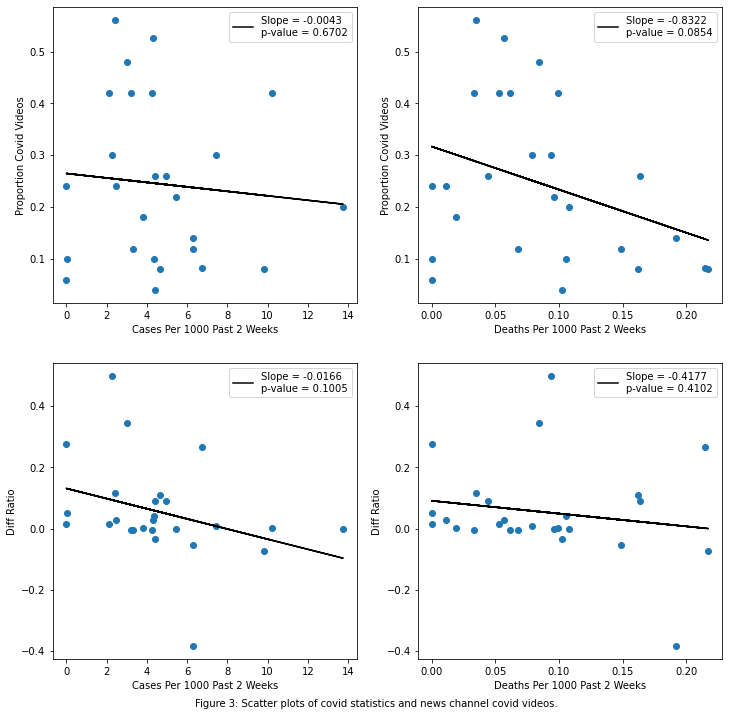

In [7]:
#Merging data
all_merged_vals = relevant_vals.merge(youtube_data_keep,left_on = 'Country',right_on = 'Country', how = 'inner')


x = all_merged_vals['cases per 1000 past 2 weeks'].to_list()
y = all_merged_vals['tot covid videos'].to_list()

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False,figsize=[12,12])

# fig.suptitle("Scatter Plots of Covid Video Statistics",x=0.5,y=0.93, fontsize=15 )
r_vals = list()
p_vals = list()
for subplt_x_val,xvals in enumerate(['cases per 1000 past 2 weeks', 'deaths per 1000 past 2 weeks']):
    for subplt_y_val, yvals in enumerate(['proportion covid videos', 'diff ratio']):
        x = all_merged_vals[xvals]
        y = all_merged_vals[yvals]
        m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        r_vals.append(r_value)
        p_vals.append(p_value)
        axs[subplt_y_val, subplt_x_val].scatter(x,y)
        axs[subplt_y_val, subplt_x_val].plot(x, m*x + b,c='k')
        axs[subplt_y_val, subplt_x_val].set(xlabel=xvals.title(),ylabel=yvals.title())
        axs[subplt_y_val, subplt_x_val].legend(['Slope = ' + str(round(m,4)) + '\np-value = '+ str(round(p_value,4))])

#         axs[subplt_y_val, subplt_x_val].text(1, 2, str(2))

fig.text(.5, .07, 'Figure 3: Scatter plots of covid statistics and news channel covid videos.', ha='center')
plt.show()

# Part 2 Discussion
After cleaning the data, the only countries remaining are those highlighted in Table 4. These countries are western countries that fit the criteria above. Table 4 also highlights the number of news channel identified for each of the 26 countries, the identified language of the news channel, the number of likes, the number of dislikes and like dislike ratio. It can be seen from this table that there are two occurences where two channels share the same news channel that fit our criteria. These countries were still used in my analysis, resulting in a few countries with the same number of video likes or Covid-19 videos (but they have a different number of confirmed Covid cases and deaths, so they are still unique data points). Table 5 highlights the cases where the algorithm failed to pick up a good match based on our criteria, as well as the languages detected for each of these channels. It can be seen that most failed cases are for non-english language channels. These results show that a more sophisticated algorithm - Perhaps a more complicated matching algorithm, or a machine learning model may be warranted in future work to yield more countries. However, it should still be noted that the majority of non-english countries were picked up using this algorithm, giving some validity to this simple approach.

Figure 4 shows that there visually appears to be a small, negative correlation between Covid cases as well as deaths per 100 people and the number of Covid-related youtube videos. It also appears that the difference in video ratings is negatively correlated with the number of Covid cases per capita (therefore the videos appear to be better received in high Covid countries compared to ordinary videos). Figure 4 also shows the slope of each of these plots. Despite these apparent correlations, none of the p values are statistically significant (p-values are greater than 0.05), therefore there does not appear to be an association between the severity of a covid outbreak, and the public's perception of Covid or the number of Covid related videos.

I approach these results with sketitism, but since there is little literature in this research area, it is challenging to contextualize my findings. Perhaps the work that most closely resembles mine is (Zhou, 2020), that analysed the effect of covid cases on public sentiment in Australia over time using twitter. They determined that the public sentiment decreases as covid cases rise. They only performed an analysis on Australia, therefore it could be that these results do not generalize to every country. It is also likely that the sample size of videos and channels I extracted for each country was too small to be representative of the country's statistics. 

# Limitations

## Part 1

For my first research question, there were several limitations to the data that I believe hampered my analysis. First, the granularity of the merged data was limited to the data source with the lowest level of granularity - In this case the world bank value surveys. For the majority of countries, this data was only available at a national level, therefore I could not fully leverage the fine-grained nature of other data sources that had data available at a sub-country level. This could be another reason that I did not find a difference between the two groups [4] was able to retrieve trust levels at a sub-country level, enabling them to isolate high and low trust areas of each country. It could be that sub-country level data would have revealed different patterns. Future work could look into other datasets to measure the public's importance to science at a more fine-grained level.

Another possible limitation of this study is surprisingly related to the diversity of countries included. As discussed earlier, the sample of countries is spread across 6 continents that have vastly different norms, government structures, and levels of economic development. Grouping countries from every continent together is extremely naive, especially for a univariate analysis. There is almost certainly other factors that incluence people's level of compliance at a continental level. This issue would not be as pronounced with a larger sample size of countries, as countries of each continent could be grouped together. However, in this study performing a fine-grained analysis by continent would likely just pick up on noise in the data due to the small sample size involved.


## Part 2
My API choices were perhaps the most limiting factors for my analysis of part 2. The quota of the youtube API meant that I could not extract very many videos, or include more contries. The overall quota cost of running the code is approximetly 200 units per country, therefore the total cost accross the 37 countries is around 7400 Units, or 74% of the daily allocated quota for the Youtube API. This had a significant impact on the design of my code, since it ensured that I needed to make API calls sparingly - If a country's top channel did not include videos that fit my criteria I could not simply re-run my search for another channel, since I would risk going over the limit (especially when I'm not sure how many re-runs I would need to make for each country). 

The API quota limit also ensured the number of videos I could query remained at 50 videos per country. This was not ideal for my analysis, since some channels may rarely post about Covid videos (less than once every 50 videos), so my algorithm would likely exclude these countries. These countries needed to be excluded because it was challenging to tell, unless I used a complex machine learning model, if a channel appeared to have no mentions of Covid because my algorithm was simply not sophisticated enough to pick it up, or if Covid videos were genuinly rare on that channel.

An additional limitation to the methods I employed is that past uploads beyond the 50 most recent uploads cannot be easily accessed. This means that my research cannot be replicated unless I save the video ids each day to be able to look back on them historically and share these ids with other researchers. Moreover, I cannot look into past trends of data, which limits my analysis' to the time period beginning when I started collecting data. Therefore I could not go back and analyze like/dislike trends of news channels from the begining of the pandemic. 


It should be noted that for future work I could pay for a larger quota limit for the Youtube API to avoid most of these challenges. API calls could be made less sparingly, therefore significantly more data could be extracted and more fine-grained trends analyzed. It is important to note that I extracted this data on December 8 2020, so it would be interesting to see how these results change over time as the number of cases change for each country. Future work could query Youtube data on a daily basis and determine temporal patterns in the data. Future work could also examine more country-level data and include more videos; However, there is a clear trade-off between how many videos can be queried and the number of countries that can be analyzed. The more videos that are included, the less channels that can be analyzed due to the Youtube API quota. This trade-off may also be why relatively few studies explore the use of Youtube data compared to Twitter, which has more generous quotas.

# References
Kristina Murphy, H. (2020, September 9). Why people comply with COVID-19 social distancing restrictions: Self-interest or duty? - Kristina Murphy, Harley Williamson, Elise Sargeant, Molly McCarthy, 2020. Retrieved December 07, 2020, from https://journals.sagepub.com/doi/full/10.1177/0004865820954484

Bargain, O., &amp; Aminjonov, U. (2020, May 14). Trust and Compliance to Public Health Policies in Times of Covid-19. Retrieved December 07, 2020, from https://poseidon01.ssrn.com/delivery.php?ID=077084099072011069096082127115025092061025017074071027094097022034075048088091127087017095101051035048102075010097029064001010121064095072029068001102011104073095000078007125022067

Authors, A., &amp; Musil, N. (2020, June 1). Modeling compliance with COVID-19 prevention guidelines: The critical role of trust in science. Retrieved December 07, 2020, from https://www.tandfonline.com/doi/full/10.1080/13548506.2020.1772988

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T., Harvey, J., . . . Tarassenko, L. (2020, January 01). OxCOVID19 Database: A multimodal data repository for better understanding the global impact of COVID-19. Retrieved December 09, 2020, from https://www.medrxiv.org/content/10.1101/2020.08.18.20177147v1

Freeman, S., &amp; Eykelbosh, A. (2020, April 14). COVID-19 and outdoor safety: Considerations for use of outdoor recreational spaces. Retrieved December 07, 2020, from https://ncceh.ca/sites/default/files/COVID-19%20Outdoor%20Safety%20-%20April%2016%202020.pdf

Pak, A., &amp; Paroubek, P. (2012). Twitter as a Corpus for Sentiment Analysis and Opinion Mining. Retrieved from https://lexitron.nectec.or.th/public/LREC-2010_Malta/pdf/385_Paper.pdf

Ortigosa, A., &amp; Martín, J. (2013). Sentiment analysis in Facebook and its application to e-learning. Computers in Human Behavior.

Montemurro, N. (2020, July). The emotional impact of COVID-19: From medical staff to common people. Retrieved December 07, 2020, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7138159/

Zhou, J., Yang, S., &amp; Chen, F. (2020, June 22). EXAMINATION OF COMMUNITY SENTIMENT DYNAMICS DUE TO COVID-19 PANDEMIC: A CASE STUDY FROM AUSTRALIA. Retrieved December 07, 2020.

In [10]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel
import io
from IPython.nbformat import current

def notebook_path():
    
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+
                    'api/sessions?token='+srv['token'])
            
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],
                                        sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

with io.open(notebook_path(), 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        if cell['source'][:12] == "# References":
            continue
        else:
            word_count += len(cell['source'].replace('#','')
                              .lstrip().split(' '))

print(f"The word count, excluding references, is {word_count}")

ModuleNotFoundError: No module named 'notebook'